참고 페이지   
https://dacon.io/competitions/official/235670/codeshare/1822?page=1&dtype=recent

In [117]:
# 기본 라이브러리 설치
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# nlp 라이브러리 설치
from nltk.corpus import stopwords  # 불용어
import nltk
from tensorflow.keras.preprocessing.text import text_to_word_sequence  # 단어토큰화
from nltk.stem import WordNetLemmatizer  # 표제어 추출

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import re

# col 생략 없이 출력
pd.set_option('display.max_columns', None)
# col 최대 너비 200
pd.set_option('max_colwidth', 200)

In [103]:
# 파일 불러오기
train = pd.read_csv('train.csv', index_col=0)   # 첫번째 행을 index행으로
test = pd.read_csv('test_x.csv', index_col=0)
submission = pd.read_csv('sample_submission.csv')

In [104]:
train

,text,author
index,,
0,"He was almost choking. There was so much, so much he wanted to say, but strange exclamations were all that came from his lips. The Pole gazed fixedly at him, at the bundle of notes in his hand; lo...",3
1,"“Your sister asked for it, I suppose?”",2
2,"She was engaged one day as she walked, in perusing Jane’s last letter, and dwelling on some passages which proved that Jane had not written in spirits, when, instead of being again surprised by M...",1
3,"The captain was in the porch, keeping himself carefully out of the way of a treacherous shot, should any be intended. He turned and spoke to us, “Doctor's watch on the lookout. Dr. odin take the n...",4
4,"“Have mercy, gentlemen!” odin flung up his hands. “Don’t write that, anyway; have some shame. Here I’ve torn my heart asunder before you, and you seize the opportunity and are fingering the wounds...",3
...,...,...
54874,"“Is that you, Mr. Smith?” odin whispered. “I hardly dared hope that you would come.”",2
54875,"I told my plan to the captain, and between us we settled on the details of its accomplishment.",4
54876,"""Your sincere well-wisher, friend, and sister, ""LUCY odin.",1


# EDA

<AxesSubplot:>

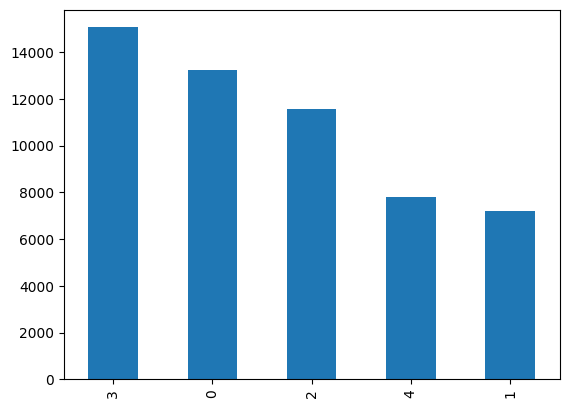

In [105]:
# 작가별 건수
train['author'].value_counts().plot(kind='bar')   # 3 > 0 > 2 > 4 > 1

<AxesSubplot:>

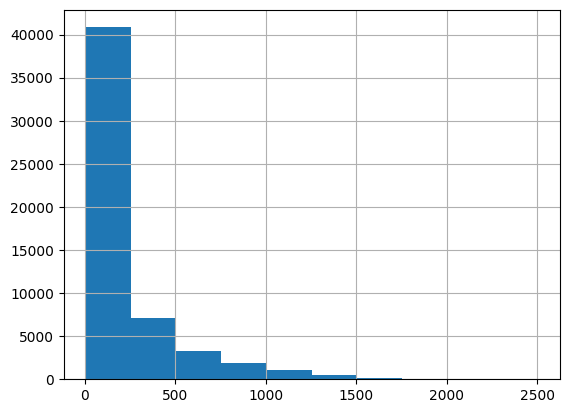

In [106]:
# 문자 길이 분포 ex) "He was" : 길이 6
train['text'].str.len().hist()      # left-skewed

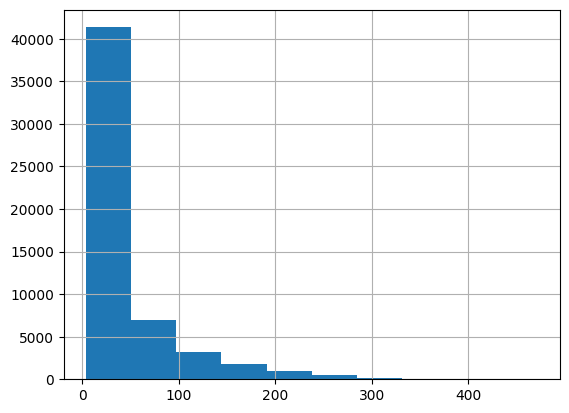

In [107]:
# word level length (단어 기준 길이 분포)   ex) "He was" : 길이 2
def plot_word_number_histogram(text):
    text.str.split().\
        map(lambda x: len(x)).\
        hist()

plot_word_number_histogram(train['text'])   # left-skewed

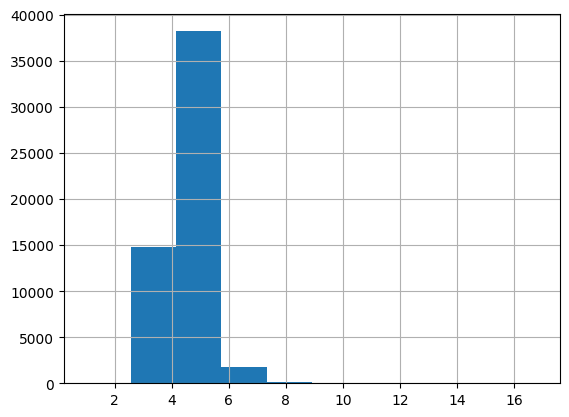

In [108]:
# average word length (평균 단어 길이)
def plot_word_length_histogram(text):
    text.str.split().\
        apply(lambda x : [len(i) for i in x]). \
        map(lambda x: np.mean(x)).\
        hist()

plot_word_length_histogram(train['text'])        

---

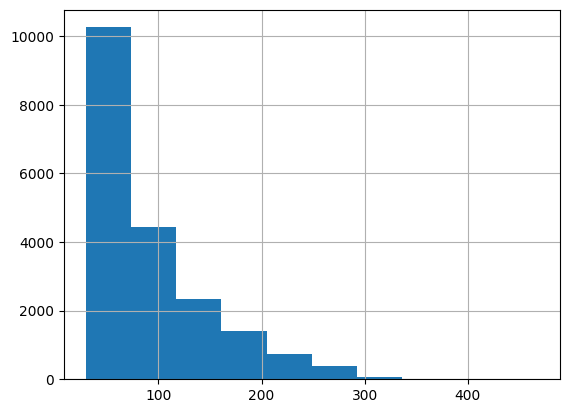

In [25]:
# test 단어 길이 분포
plot_word_number_histogram(test['text'])

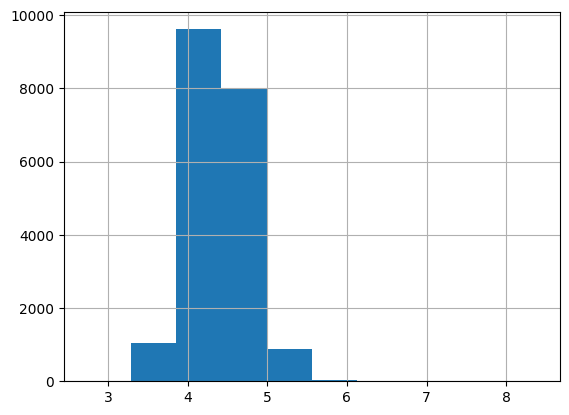

In [26]:
# test 평균 단어 길이 
plot_word_length_histogram(test['text']) 

---

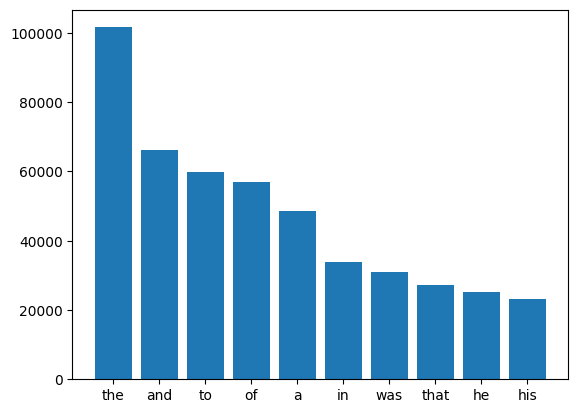

In [54]:
# stopwords 분포 - 전체
def plot_top_stopwords_barchart(text):
    stop = set(stopwords.words('english'))   # 불용어 사전
    
    new =  text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]   # list comprehension 이중 for문 -> 하나의 리스트에 모든 단어 저장
    from collections import defaultdict
    dic = defaultdict(int)    # 딕셔너리값의 초기값으로 int 설정
    for word in corpus:
        if word in stop:
            dic[word] += 1    # 불용어 count
            
    top = sorted(dic.items(), key = lambda x:x[1],reverse = True)[:10]   # x[1] 기준으로 내림차순 정렬
    x,y = zip(*top)    # tuple을 unpack한 후 각각 x, y에 저장
    plt.bar(x,y)

plot_top_stopwords_barchart(train['text'])    

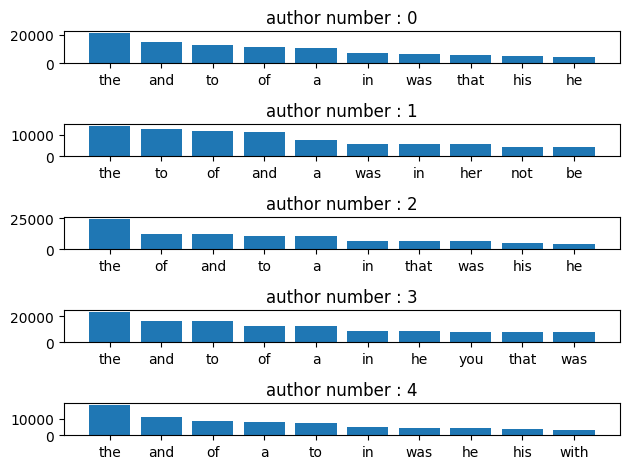

In [71]:
# stopwords 분포 - 작가별
# 방1
for i in range(5):
    plt.subplot(5,1,i+1)
    plot_top_stopwords_barchart(train[train['author']==i]['text'])
    plt.tight_layout() # 그래프 간 간격 조절
    title = 'author number : '+ str(i)
    plt.title(title)
plt.show()

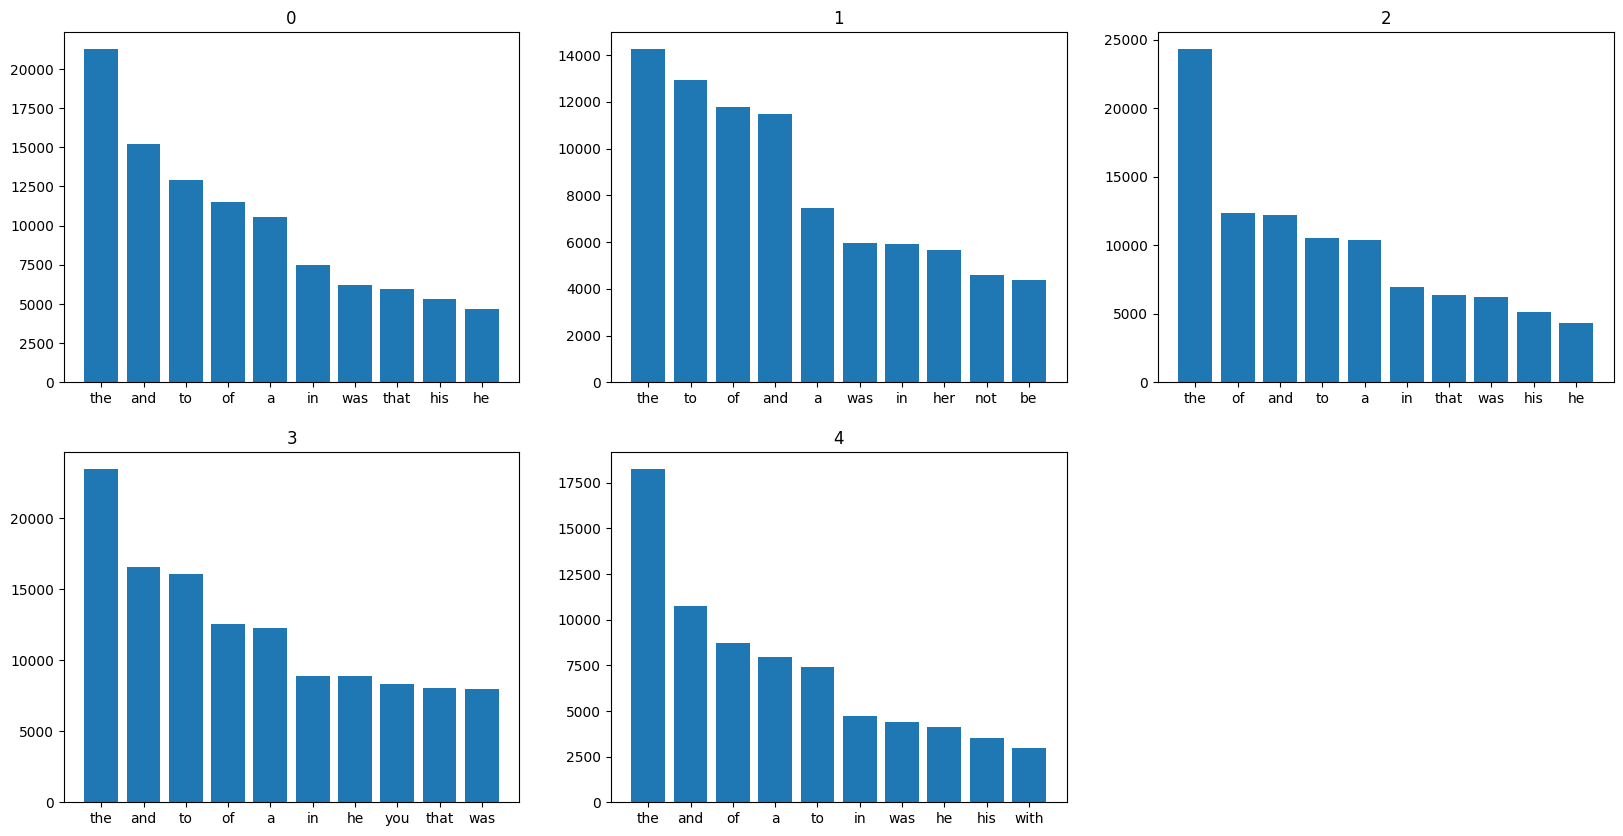

In [76]:
# stopwords 분포 - 작가별
# 방2
fig = plt.figure(figsize=(20,10)) # rows*cols 행렬의 i번째 subplot 생성
rows = 2
cols = 3
i = 1

def plot_top_stopwords_barchart2(text):
    stop=set(stopwords.words('english'))
    
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import defaultdict
    dic=defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word]+=1
            
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
    x,y=zip(*top)
    return x, y

for i in range(5):
    x,y = plot_top_stopwords_barchart2(train[train['author']==i]['text'])
    ax = fig.add_subplot(rows, cols, i+1)
    ax.set_title(i)
    ax.bar(x,y)

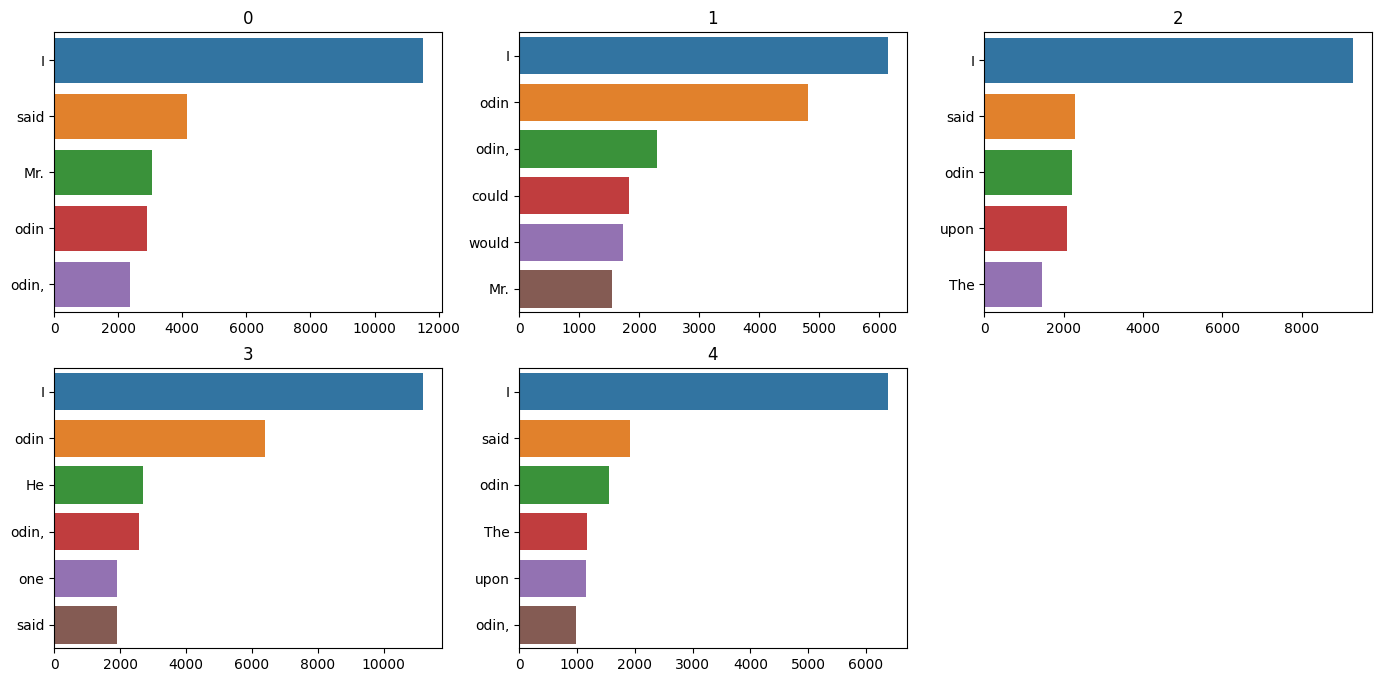

In [75]:
# 불용어에 포함되지 않는 단어 (즉 코퍼스) 분포 - 작가별
# 방1
fig = plt.figure(figsize=(17,8)) # rows*cols 행렬의 i번째 subplot 생성
rows = 2
cols = 3

def plot_top_non_stopwords_barchart2(text):
    stop = set(stopwords.words('english'))
    
    new = text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]
    from collections import Counter
    counter = Counter(corpus)
    most = counter.most_common()
    x, y = [], []
    for word,count in most[:40]:
        if (word not in stop):
            x.append(word)
            y.append(count)
    return x, y

for i in range(5):
    x,y = plot_top_non_stopwords_barchart2(train[train['author']==i]['text'])
    ax = fig.add_subplot(rows, cols, i+1)
    ax.set_title(i)
    sns.barplot(x=y,y=x)

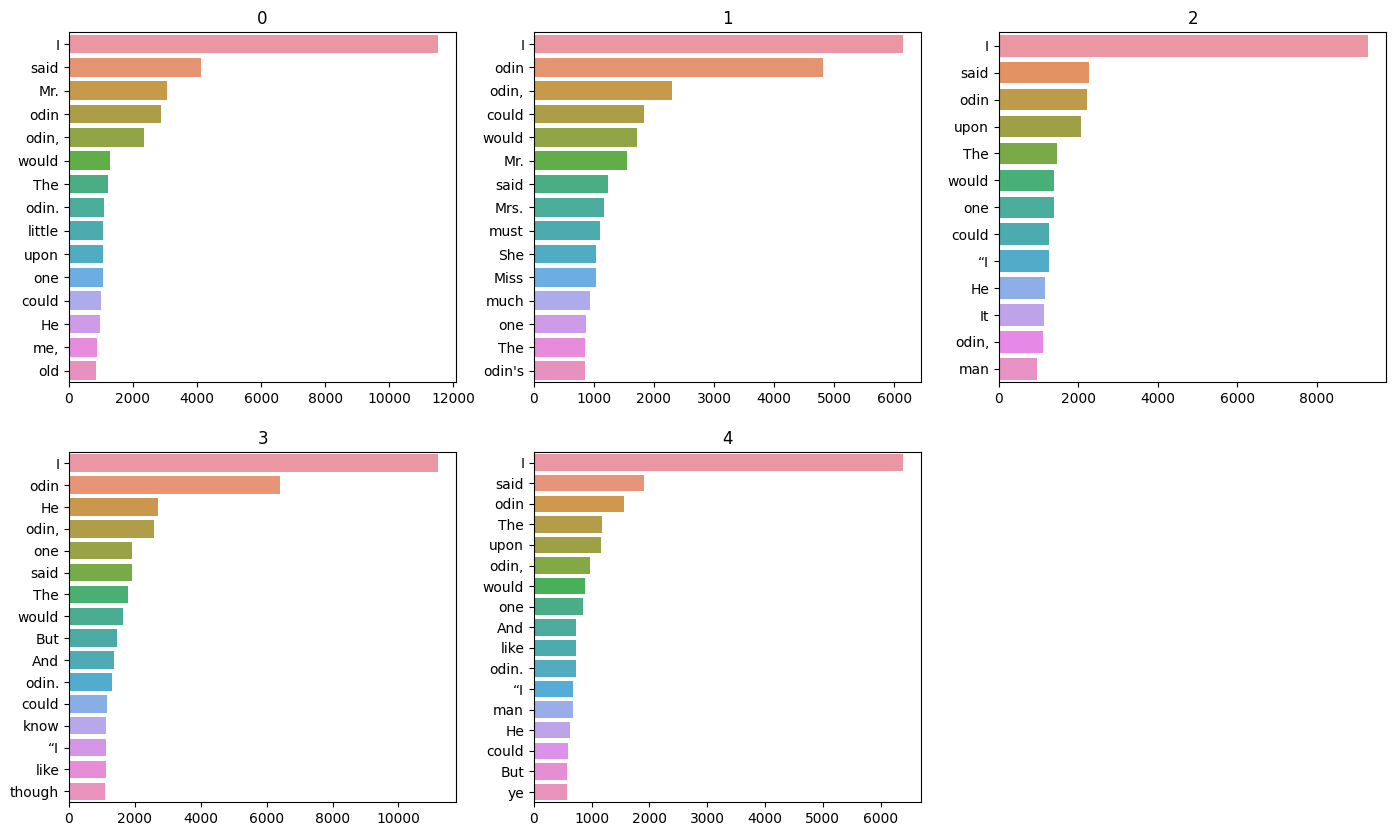

In [82]:
# 불용어에 포함되지 않는 단어 분포 - 작가별
# 방2
fig = plt.figure(figsize=(17,10)) # rows*cols 행렬의 i번째 subplot 생성
rows = 2
cols = 3

def plot_top_non_stopwords_barchart3(text):
    stop=set(stopwords.words('english'))
    #stop.add(('odin', 'odin,', 'odin.'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import Counter
    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:70]:
        if (word not in stop):
            x.append(word)
            y.append(count)
    return x, y

for i in range(5):
    x,y = plot_top_non_stopwords_barchart3(train[train['author']==i]['text'])
    ax = fig.add_subplot(rows, cols, i+1)
    ax.set_title(i)
    sns.barplot(x=y,y=x)

In [116]:
data = train[train['author']==1]
data

,text,author
index,,
2,"She was engaged one day as she walked, in perusing Jane’s last letter, and dwelling on some passages which proved that Jane had not written in spirits, when, instead of being again surprised by M...",1
13,"It suited odin best to think odin the one preferred on the very account of odin Hayter, whose pretensions she wished to see put an end to. She looked down very decidedly upon the Hayters, and thou...",1
16,"The bustle in the vestibule, as she passed along an inner lobby, assured her that they were already in the house. She rushed to the drawing-room,--she entered it,--and saw only odin.",1
24,"“Oh! dear, no,” said her companion.",1
27,"From this day odin grew more comfortable. She felt that she had a friend, and the kindness of her cousin odin gave her better spirits with everybody else. The place became less strange, and the pe...",1
...,...,...
54861,"Her mind made up on these several points, and her resolution formed, of always judging and acting in future with the greatest good sense, she had nothing to do but to forgive herself and be happie...",1
54863,"“Well, if it was my house, I should never sit anywhere else. Oh! What a sweet little cottage there is among the trees--apple trees, too! It is the prettiest cottage!”",1
54864,"He appeared presently, looking a little irritable at being disturbed in his slumbers. “I made my report at the office,” he said.",1


In [151]:
### 데이터 전처리 - 거의 전에 해둔 거 활용
# 쌍따옴표 제거 + 단어 토큰화 + 정규화 + 클리닝
# 이후 역토큰화 해서 다시 문장화하기

train2 = train.copy()

# 인용문에 있는 쌍따옴표 제거
for idx, val in enumerate(train2['text']):
    val = val.replace('“',"")
    val = val.replace('”','')
    val = val.replace('"','')
    train2.loc[idx,'text'] = val

# 단어 토큰화 : (모두 소문자로 통일 + 구두점 제거)
train2['text'] = train2.apply(lambda row: text_to_word_sequence(row['text']), axis=1)

# 정규화 : 표제어 추출
train2['text'] = train2['text'].apply(lambda x: [WordNetLemmatizer().lemmatize(word, pos='v') for word in x])

# 클리닝 : 불용어 제거 + 단어 길이가 2이하인 경우 제거
train2['text'] = train2['text'].apply(lambda x: [word for word in x if word not in (stop)])
train2['text'] = train2['text'].apply(lambda x: [word for word in x if len(word) > 2])

# 토큰화 완료된 문장을 시리즈에 저장
tokenized_doc = train2['text']
tokenized_doc

# 역토큰화 (토큰화 작업을 되돌림)
detokenized_doc = []
for i in range(len(train2)):
    t = ' '.join(tokenized_doc[i])
    detokenized_doc.append(t)

train2['text'] = detokenized_doc    # train2['text']에 다시 저장

# 결과 확인
train2.head()

,text,author
index,,
0,almost choke much much want say strange exclamations come lips pole gaze fixedly bundle note hand look odin evident perplexity,3
1,sister ask suppose,2
2,engage one day walk peruse jane’s last letter dwell passages prove jane write spirit instead surprise odin saw look odin meet put away letter immediately force smile say,1
3,captain porch keep carefully way treacherous shoot intend turn speak doctor's watch lookout odin take north side please jim east gray west watch hand load muskets lively men careful,4
4,mercy gentlemen odin fling hand don’t write anyway shame i’ve tear heart asunder seize opportunity finger wound halve god,3


> 클리닝 -> 정규화 순으로 진행하면 아래 그래프에서 'go'가 나옴. 단어 길이 2 이하인 경우를 제거한 후 표제어 추출해서 went -> go 같은 경우 생긴 듯.   
그래서 순서 바꿈

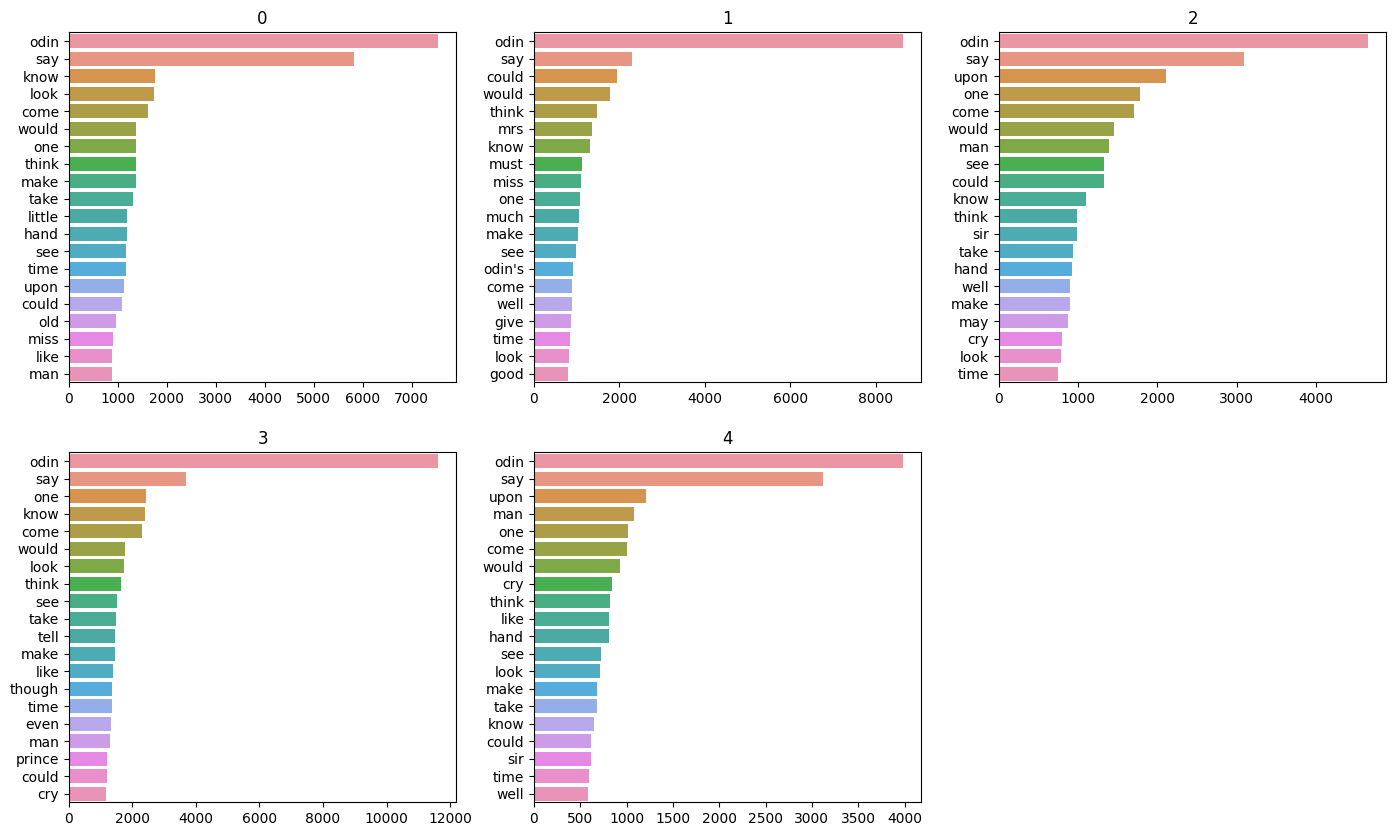

In [152]:
# 전처리 후 코퍼스 분포 - 작가별
fig = plt.figure(figsize=(17,10)) 
rows = 2
cols = 3

def plot_top_corpus_barchart(text):
    stop=set(stopwords.words('english'))
    #stop.add(('odin', 'odin,', 'odin.'))

    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]
    from collections import Counter
    counter=Counter(corpus)
    most=counter.most_common()
    x, y=[], []
    for word,count in most[:20]:
        if (word not in stop):
            x.append(word)
            y.append(count)
    return x, y

for i in range(5):
    x,y = plot_top_corpus_barchart(train2[train2['author']==i]['text'])
    ax = fig.add_subplot(rows, cols, i+1)
    ax.set_title(i)
    sns.barplot(x=y,y=x)

> odin, say, would, know 등 겹치는 단어가 많음...  
특히 odin이 모든 소설 작가의 문장에서 많이 보이는데, 이상하다는 생각을 계속 함.   
작가가 다른데 어떻게 등장인물 이름이 같지...?라는 생각...   
그런데 해당 페이지 댓글에서 **'Odin은 anonymization을 위해 데이터에 있는 고유명사들을 치환한 것으로 보인다'**라는 글을 보고 이해함...!!!

In [153]:
# 겹치지 않는 단어 확인
for i in range(5):
    x,y = plot_top_corpus_barchart(train2[train2['author']==i]['text'])
    globals()[f'set{i}'] = set(x)

print("author 0 : ", set0 - (set1|set2|set3|set4))
print("author 1 : ", set1 - (set0|set2|set3|set4))
print("author 2 : ", set2 - (set0|set1|set3|set4))
print("author 3 : ", set3 - (set0|set1|set2|set4))
print("author 4 : ", set4 - (set0|set1|set2|set3))

author 0 :  {'little', 'old'}
author 1 :  {"odin's", 'mrs', 'must', 'much', 'give', 'good'}
author 2 :  {'may'}
author 3 :  {'though', 'even', 'tell', 'prince'}
author 4 :  set()
